## __5.4 단순 계층__

#### 곱셈계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y  # x와 y를 바꾼다.
        dy = dout * self.x

        return dx, dy

In [2]:
apple=100
apple_num=2
tax=1.1

# 계층
mul_apple_layer=MulLayer()
mul_tax_layer=MulLayer()

# 순전파
apple_price=mul_apple_layer.forward(apple, apple_num) # 100 * 2 =200
price=mul_tax_layer.forward(apple_price, tax)  # 200 * 1.1 = 220

print(price) 

220.00000000000003


사과

In [3]:
# 역전파
dprice=1
dapple_price, dtax=mul_tax_layer.backward(dprice)
dapple, dapple_num=mul_apple_layer.backward(dapple_price)

print(dapple)
print(dapple_num)
print(dtax) 

2.2
110.00000000000001
200


#### 덧셈계층

In [5]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

사과 + 오렌지

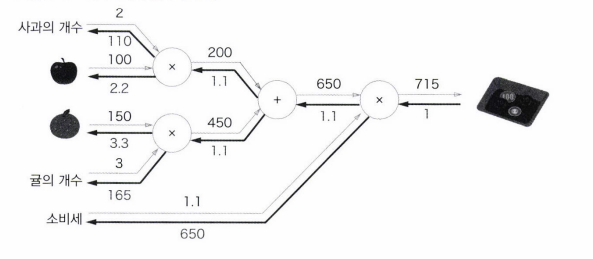

In [7]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice=1
dall_price, dtax=mul_tax_layer.backward(dprice) 
dapple_price, dorange_price=add_apple_orange_layer.backward(dall_price) 
dorange, dorange_num=mul_orange_layer.backward(dorange_price) 
dapple, dapple_num=mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple)
print(dorange, dorange_num)
print(dtax)

715.0000000000001
110.00000000000001 2.2
3.3000000000000003 165.0
650


## __5.5 활성화 함수__

#### ReLU

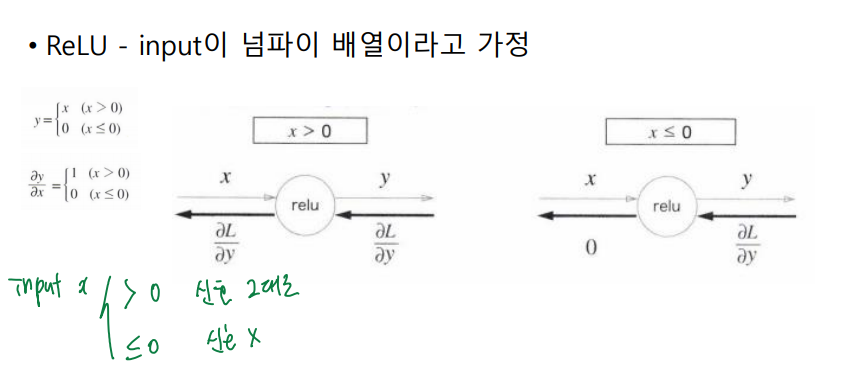

In [10]:
import numpy as np
x = np.array( [[1.0, -0.5], [-2.0, 3.0]])
print(x)

mask = (x<=0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


In [11]:
x[mask] 

array([-0.5, -2. ])

In [8]:
class ReLU:
    def __init__(self):
        self.mask=None
    # -1, -4, 4, 5, 2, -3 mask T / F
    def forward(self, x):
        self.mask(x<=0) 
        out=x.copy()
        out[self.mask]=0 # 0이하인 애들 0으로 바꿈
    
    def backward(self, dout):
        dout[self.mask]=0
        dx=dout
        
        return dx

#### Sigmoid

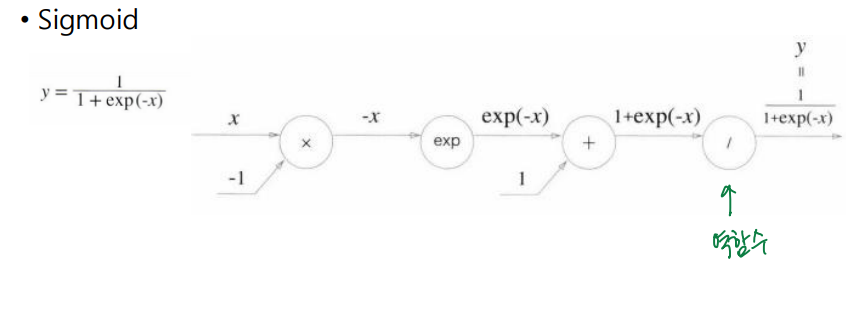

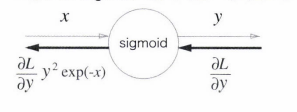

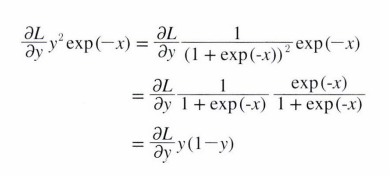

In [12]:
class Sigmoid:
    def __init__(self):
        self.out=None
    
    def forward(self, x):
        out=1/(1+np.exp(-x))
        self.out=out
    
    def backward(self, dout):
        dx=dout*(1.0-self.out)*self.out
        
        return dx

## __5.6 Affine/Softmax 계층__

#### Affine 계층 

In [8]:
import numpy as np
X_dot_W=np.array([[0,0,0], [10,10,10]]) 
B=np.array([1,2,3])

print(X_dot_W) 
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


In [16]:
class Affine:
    def __init__(self, W, b):
        self.W=W
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
        
    def forward(self, x):
        self.x=x
        out=np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx=np.dot(dout, self.W.T)
        self.dW=np.dot(self.x.T, dout)
        self.db=np.sum(dout, axis=0)
        
        return dx

#### Softmax-with-loss 계층

In [14]:
def softmax(a):
    c=np.max(a)
    exp_a=np.exp(a-c)
    sum_exp_a=np.sum(exp_a)
    y=exp_a / sum_exp_a
    
    return y

def cross_entropy_error(y, t):
    if y.ndim==1:
        t=t.reshape(1, t.size)
        y=y.reshape(1, y.size)
        
    batch_size=y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))/batch_size

In [15]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss=None
        self.y=None
        self.t=None
        
    def forward(self, x, t):
        self.t=t
        self.y=softmax(x)
        self.loss=cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size=self.t.shape[0]
        dx=(self.y-self.t)/batch_size
        
        return dx

## __5.7 오차역전파법__

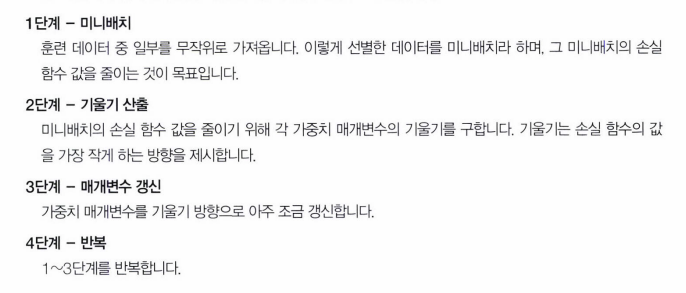

In [17]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from collections import OrderedDict # 순서가 있는 딕셔너리
from common.layers import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params={}
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2']=np.zeros(output_size)
        
        # 계층생성
        self.layers=OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLU1']=Relu()
        self.layers['Affine2']=Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer=SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x=layer.forward(x)
            
        return x
    
    # x 입력데이터 t 정답 레이블
    def loss(self, x, t):
        y=self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y=self.predict(x)
        y=np.argmax(y, axis=1)
        if t.ndim != 1 : t=np.argmax(t, axis=1)
            
        accuracy=np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    # x 입력데이터 t 정답레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x, t)
        
        grads={}
        grads['W1']=numerical_gradient(loss_W, self.params['W1'])
        grads['b1']=numerical_gradient(loss_W, self.params['b1'])
        grads['W2']=numerical_gradient(loss_W, self.params['W2'])
        grads['b2']=numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout=1
        dout=self.lastLayer.backward(dout)
        
        layers=list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout=layer.backward(dout)
            
        # 결과저장
        grads={}
        grads['W1']=self.layers['Affine1'].dW
        grads['b1']=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW
        grads['b2']=self.layers['Affine2'].db
        
        return grads

#### 기울기 확인

In [18]:
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test)=load_mnist(normalize=True, one_hot_label=True)

network=TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch=x_train[:3]
t_batch=t_train[:3]

grad_numerical=network.numerical_gradient(x_batch, t_batch)
grad_backprop=network.gradient(x_batch, t_batch)

# 각 가중치 차이의 절대값을 구한 후 절대값들의 평균 계산
for key in grad_numerical.keys():
    diff=np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ";" + str(diff)) 

W1;3.833590245713173e-10
b1;2.198056700099065e-09
W2;5.659560141475021e-09
b2;1.3992515855293376e-07


#### 오차역전파법을 이용한 학습 

In [19]:
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch=max(train_size/batch_size, 1)

for i in range(iters_num):
    batch_mask=np.random.choice(train_size, batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]
    
    # 오차역전파법으로 기울기 구함
    grad=network.gradient(x_batch, t_batch)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i%iter_per_epoch==0:
        train_acc=network.accuracy(x_train, t_train)
        test_acc=network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc) 

0.10173333333333333 0.0959
0.9074333333333333 0.9105
0.92355 0.9252
0.9359666666666666 0.935
0.9457166666666666 0.9446
0.95075 0.9477
0.95375 0.951
0.9608833333333333 0.9556
0.9636333333333333 0.9573
0.96525 0.9594
0.9692 0.9625
0.9715666666666667 0.9651
0.9722 0.9647
0.9752833333333333 0.9658
0.9769 0.9682
0.97715 0.9674
0.9792333333333333 0.9688
